<a href="https://colab.research.google.com/github/GangisettySreeshanth/AIML_labs_Projects/blob/main/Copy_of_STP_Module_4_Lab_2_Introduction_to_Gradient_Descent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Student Training Program on AIML**
# Module 4: Perceptron and Gradient Descent
## Lab 2: Introduction to Gradient Descent

Understanding Gradient Descent is crucial because it is the backbone of how most machine learning and deep learning models, including neural networks, are trained.

# A Brief Overview of the Gradient Descent Algorithm

Imagine you are standing on a mountain in a thick fog and you want to get to the lowest point in the valley. What would you do? You would likely look at the ground around your feet, find the direction of the steepest slope downwards, and take a small step in that direction. You would repeat this process until you reach the bottom.

**Gradient Descent** works exactly like this. The "mountain" is our **loss function**, which measures how wrong our model's predictions are. The "lowest point" is the set of model parameters (weights) that gives the minimum possible error.

The algorithm can be summarized in three steps:

1. Start with a random initialization of the solution (random model parameters).
2. Calculate the gradient of the loss function. The gradient is a vector that points in the direction of the steepest ascent (uphill).
3. Incrementally change the solution by moving in the direction of the negative gradient (downhill).
4. Repeat the previous steps until the loss stops decreasing, which means we have reached a minimum.

The key equation for updating the model's weights is:

$$
w_{k+1} \leftarrow w_k - \eta \nabla J
$$

Let's break this down:

- $w_{k+1}$ are the new, updated weights for our model.
- $w_k$ are the current weights.
- $\eta$ (eta) is the **learning rate**. This is a small number that controls how big of a step we take in the downhill direction.
- $\nabla J$ (nabla J) is the **gradient of the loss function** $J$. It tells us the direction of the steepest ascent. By subtracting it, we move in the opposite direction (downhill).




### Setting up the Environment

Let's begin by importing the required libraries and setting random seeds for reproducibility. This ensures that every time we run the code, we get the same "random" numbers.

In [87]:
import numpy as np
import matplotlib.pyplot as plt
import random

random.seed(42)
np.random.seed(42)

### Creating Our Dataset

To understand **Gradient Descent**, we need a problem to solve. We will try to model a second-degree polynomial equation of the form:

$$
y = ax^2 + bx + c
$$

Our goal will be to use **Gradient Descent** to find the optimal values for the coefficients **a**, **b**, and **c** that best fit a set of data points. We start by creating this data ourselves so we know the "true" answer to aim for.

Let's choose the coefficients for our ground-truth polynomial. We'll use:

$$
y = 1x^2 + 0x + 0
$$

which simplifies to:

$$
y = x^2
$$


In [88]:
def eval_2nd_degree(coeffs, x):
    """
    Function to return the output of evaluating a second degree polynomial,
    given a specific x value.

    Args:
        coeffs: List containing the coefficients a, b, and c for the polynomial.
        x: The input x value to the polynomial.

    Returns:
        y: The corresponding output y value for the second degree polynomial.

    """

    a = coeffs[0] * (x * x)
    b = coeffs[1] * x
    c = coeffs[2]
    y = a + b + c
    return y

hundred_xs = np.random.uniform(-10, 10, 100)
coeffs = [2,-3,5]

xs = []
ys = []
for x in hundred_xs:
    y  = eval_2nd_degree(coeffs, x)
    xs.append(x)
    ys.append(y)

In [89]:
import seaborn as sns

<Axes: >

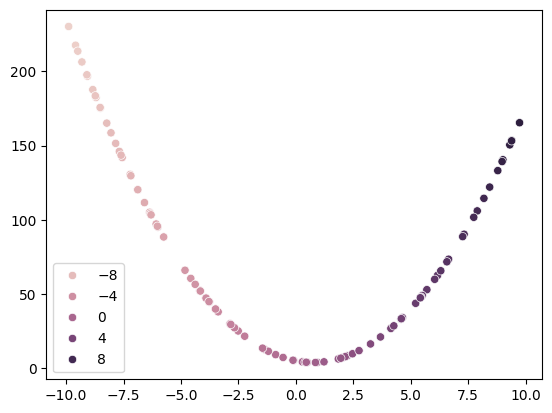

In [90]:
sns.scatterplot(x=xs,y=ys,hue=xs)

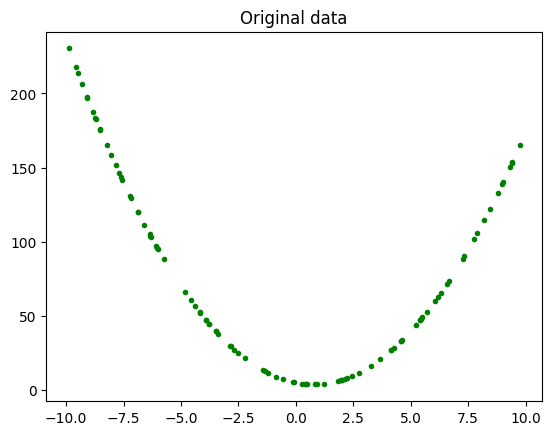

In [91]:
plt.plot(xs, ys,'g.')
plt.title('Original data')
plt.show()

This data looks perfect, but real-world data is never this clean. It always contains some amount of noise or random error. To make our problem more realistic, let's add some "jitter" (random noise) to our y-values.

In [92]:
def eval_2nd_degree_jitter(coeffs, x, j):
    """
    Function to return the noisy output of evaluating a second degree polynomial,
    given a specific x value. Output values can be within [y − j, y + j].

    Args:
        coeffs: List containing the coefficients a, b, and c for the polynomial.
        x: The input x value to the polynomial.
        j: Jitter parameter, to introduce noise to output y.

    Returns:
        y: The corresponding jittered output y value for the second degree polynomial.

    """

    a = coeffs[0] * (x * x)
    b = coeffs[1] * x
    c = coeffs[2]
    y = a + b + c

    '''  interval = [y - j, y + j]
    interval_min = interval[0]
    interval_max = interval[1]
    jit_val = random.random() * interval_max    # Generate a random number in range 0 to interval max
    jit_val = y + random.uniform(-j,j)

    while interval_min > jit_val:                 # While the random jitter value is less than the interval min,
        jit_val = random.random() * interval_max  # it is not in the right range. Re-roll the generator until it
                                                  # give a number greater than the interval min.'''
    jit_val = y + random.uniform(-j,j) # by replacing above lines with is  we can reduce no.of lines and it is easy to understand as well

    return jit_val

xs = []
ys = []
for x in hundred_xs:
    y  = eval_2nd_degree_jitter(coeffs, x, 0.1)
    xs.append(x)
    ys.append(y)


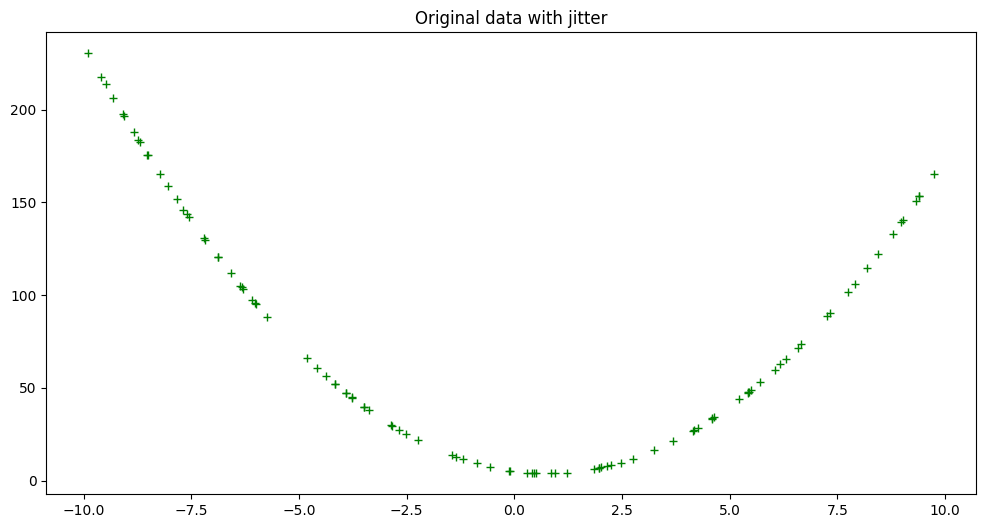

In [93]:
plt.figure(figsize=(12, 6))
plt.plot(xs, ys, 'g+')
plt.title('Original data with jitter')
plt.show()

This noisy data is what our model will see. The challenge is to find coefficients a, b, and c that create a parabola that best fits this scattered data.


# The Loss Function

To use **Gradient Descent**, we need a way to measure how "good" or "bad" our model is. This is done using a **loss function** (also called a cost function or objective function). For regression problems like this, the most common loss function is the **Mean Squared Error (MSE)**.

The MSE is calculated as the average of the squared differences between the true **y** values ($y_i$) and our model's predicted **y** values ($\bar{y_i}$):

$$
E = \frac{1}{n} \sum_{i=1}^{n} (y_i - \bar{y_i})^2
$$

We square the difference to ensure all errors are positive and to heavily penalize larger errors.


In [94]:
def loss_mse(ys, y_bar):
    """
    Calculates MSE loss.

    Args:
        ys: training data labels
        y_bar: prediction labels

    Returns: Calculated MSE loss.
    """

    return sum((ys - y_bar) **2) / len(ys)

Let's start with a completely random model. We'll pick random coefficients and see how poorly it performs.

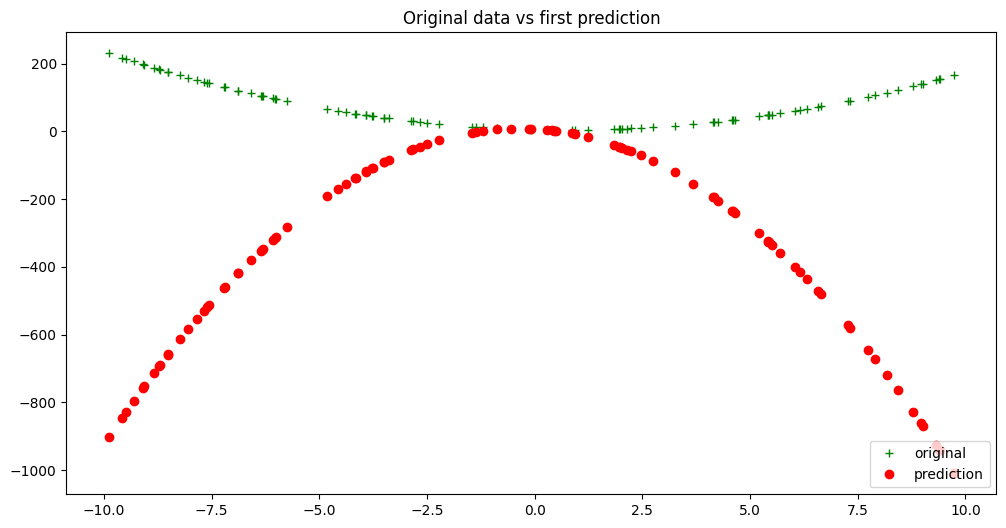

In [95]:
# Pick random coefficients for our initial model
rand_coeffs = (random.randrange(-10, 10), random.randrange(-10, 10), random.randrange(-10, 10))

# Get the model's predictions
y_bar = eval_2nd_degree(rand_coeffs, hundred_xs)

# Plot the original data vs. our random model's prediction
plt.figure(figsize=(12, 6))
plt.plot(xs, ys, 'g+', label = 'original')
plt.plot(xs, y_bar, 'ro', label = 'prediction')
plt.title('Original data vs first prediction')
plt.legend(loc="lower right")
plt.show()

Now, let's calculate the MSE for this terrible initial model.

In [96]:
initial_model_loss = loss_mse(ys, y_bar)
print(initial_model_loss)

302309.9704166699


We can see that the loss is quite a large number. Let’s now see if we can improve on this fairly high loss metric by optimizing the model with gradient descent.

We wish to improve our model. Therefore we want to alter its coefficients $a$, $b$ and $c$ to decrease the error. Therefore we require knowledge about how each coefficient affects the error. This is achieved by calculating the partial derivative of the loss function with respect to **each** of the individual coefficients.

### Calculating the Gradient

To descend the loss "mountain," we need to know which way is downhill. This is where calculus comes in. The **gradient** tells us the direction of the steepest ascent. For our loss function **E**, the gradient is a vector of its partial derivatives with respect to each of our model's coefficients (**a**, **b**, **c**):

$$
\nabla E = \left[ \frac{\partial E}{\partial a}, \frac{\partial E}{\partial b}, \frac{\partial E}{\partial c} \right]
$$

Let's derive the partial derivative with respect to **a**. Our loss function is:

$$
E = \frac{1}{n} \sum (y_i - \bar{y_i})^2
$$

and our prediction is:

$$
\bar{y_i} = a x_i^2 + b x_i + c
$$

Using the chain rule:

$$
\frac{\partial E}{\partial a} = \frac{1}{n} \sum \frac{\partial}{\partial a} \left( y_i - (a x_i^2 + b x_i + c) \right)^2
$$

$$
\frac{\partial E}{\partial a} = \frac{1}{n} \sum 2(y_i - \bar{y_i}) \cdot \frac{\partial}{\partial a} \left( - (a x_i^2) \right)
$$

$$
\frac{\partial E}{\partial a} = -\frac{2}{n} \sum (y_i - \bar{y_i}) \cdot x_i^2
$$

Similarly, for **b** and **c**:

$$
\frac{\partial E}{\partial b} = -\frac{2}{n} \sum (y_i - \bar{y_i}) \cdot x_i
$$

$$
\frac{\partial E}{\partial c} = -\frac{2}{n} \sum (y_i - \bar{y_i})
$$

The code below implements these formulas to calculate the gradient.


In [97]:
def calc_gradient_2nd_poly(rand_coeffs, hundred_xs, ys):
    """
    calculates the gradient for a second degree polynomial.

    Args:
        coeffs: a,b and c, for a 2nd degree polynomial [ y = ax^2 + bx + c ]
        inputs_x: x input datapoints
        outputs_y: actual y output points

    Returns: Calculated gradients for the 2nd degree polynomial, as a tuple of its parts for a,b,c respectively.

    """

    a_s = []
    b_s = []
    c_s = []

    y_bars = eval_2nd_degree(rand_coeffs, hundred_xs)

    for x, y, y_bar in list(zip(hundred_xs, ys, y_bars)):    # take tuple of (x datapoint, actual y label, predicted y label)
        x_squared = x ** 2
        partial_a = x_squared * (y - y_bar)
        a_s.append(partial_a)
        partial_b = x * (y - y_bar)
        b_s.append(partial_b)
        partial_c = (y - y_bar)
        c_s.append(partial_c)

    num = [i for i in y_bars]
    n = len(num)

    gradient_a = (-2 / n) * sum(a_s)
    gradient_b = (-2 / n) * sum(b_s)
    gradient_c = (-2 / n) * sum(c_s)

    return (gradient_a, gradient_b, gradient_c)   # return calculated gradients as a a tuple of its 3 parts

### Taking a Single Step

Now that we can calculate the gradient, we can take our first step of **Gradient Descent**. We will update our random coefficients using the rule:

`new_coeff = old_coeff - learning_rate * gradient`


In [98]:
# Calculate the gradients for our random model
calc_grad = calc_gradient_2nd_poly(rand_coeffs, hundred_xs, ys)

# Define a learning rate
lr = 0.0001

# Update the coefficients
a_new = rand_coeffs[0] - lr * calc_grad[0]
b_new = rand_coeffs[1] - lr * calc_grad[1]
c_new = rand_coeffs[2] - lr * calc_grad[2]
new_model_coeffs = (a_new,b_new,c_new)

print(f"New model coeffs: {new_model_coeffs}")

# Get predictions with the new coefficients
new_y_bar = eval_2nd_degree(new_model_coeffs, hundred_xs)
updated_model_loss = loss_mse(ys, new_y_bar)

print(f"Now have smaller model loss: {updated_model_loss} vs {initial_model_loss}")

New model coeffs: (np.float64(-4.925168453388591), np.float64(-7.066838594796601), np.float64(7.084086047369429))
Now have smaller model loss: 99663.3218501993 vs 302309.9704166699


Success! Just one step in the right direction has dramatically reduced our model's loss. Let's visualize this improvement.

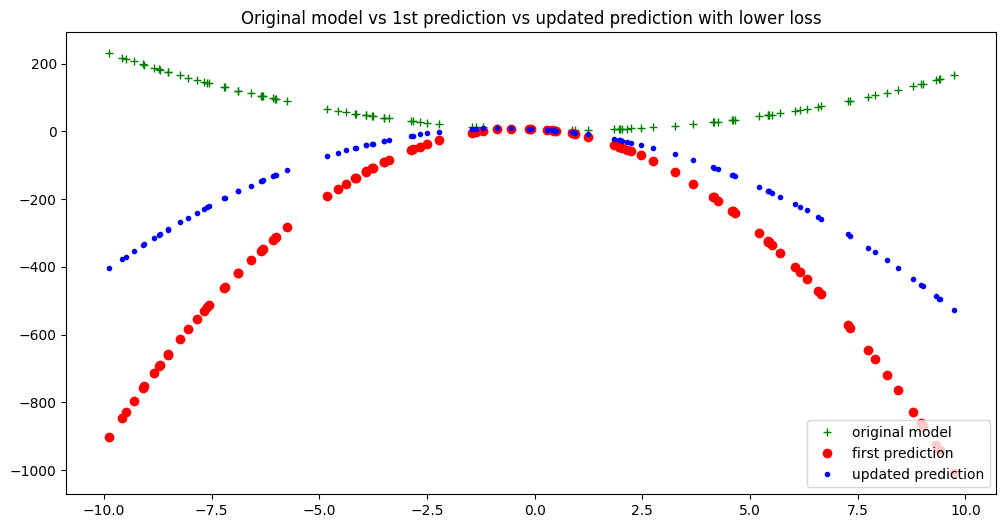

In [99]:
plt.figure(figsize=(12, 6))
plt.plot(xs, ys, 'g+', label = 'original model')
plt.plot(xs, y_bar, 'ro', label = 'first prediction')
plt.plot(xs, new_y_bar, 'b.', label = 'updated prediction')
plt.title('Original model vs 1st prediction vs updated prediction with lower loss')
plt.legend(loc="lower right")
plt.show()

The blue dots (the updated prediction) are already a much better fit than the red circles (the initial random guess).

### The Full Gradient Descent Loop

We’re almost ready. The last step will be to perform gradient descent iteratively over a number of epochs (cycles or iterations.) With every epoch we hope to see an improvement in the form of lowered loss, and better model-fitting to the original data.

In [100]:
def calc_gradient_2nd_poly_for_GD(coeffs, inputs_x, outputs_y, lr):
    """
    calculates the gradient for a second degree polynomial.

    Args:
        coeffs: a,b and c, for a 2nd degree polynomial [ y = ax^2 + bx + c ]
        inputs_x: x input datapoints
        outputs_y: actual y output points
        lr: learning rate

    Returns: Calculated gradients for the 2nd degree polynomial, as a tuple of its parts for a,b,c respectively.

    """
    a_s = []
    b_s = []
    c_s = []

    y_bars = eval_2nd_degree(coeffs, inputs_x)

    for x,y,y_bar in list(zip(inputs_x, outputs_y, y_bars)):    # take tuple of (x datapoint, actual y label, predicted y label)
        x_squared = x ** 2
        partial_a = x_squared * (y - y_bar)
        a_s.append(partial_a)
        partial_b = x * (y - y_bar)
        b_s.append(partial_b)
        partial_c = (y - y_bar)
        c_s.append(partial_c)

    num = [i for i in y_bars]
    n = len(num)

    gradient_a = (-2 / n) * sum(a_s)
    gradient_b = (-2 / n) * sum(b_s)
    gradient_c = (-2 / n) * sum(c_s)


    a_new = coeffs[0] - lr * gradient_a
    b_new = coeffs[1] - lr * gradient_b
    c_new = coeffs[2] - lr * gradient_c

    new_model_coeffs = (a_new, b_new, c_new)

    # update with these new coeffs:
    new_y_bar = eval_2nd_degree(new_model_coeffs, inputs_x)

    updated_model_loss = loss_mse(outputs_y, new_y_bar)
    return updated_model_loss, new_model_coeffs, new_y_bar

In [101]:
def gradient_descent(epochs, lr):
    """
    Perform gradient descent for a second degree polynomial.

    Args:
        epochs: number of iterations to perform of finding new coefficients and updatingt loss.
        lr: specified learning rate

    Returns: Tuple containing (updated_model_loss, new_model_coeffs, new_y_bar predictions, saved loss updates)

    """
    losses = []
    rand_coeffs_to_test = rand_coeffs
    for i in range(epochs):
        loss = calc_gradient_2nd_poly_for_GD(rand_coeffs_to_test, hundred_xs, ys, lr)
        rand_coeffs_to_test = loss[1]
        losses.append(loss[0])
    print(losses)
    return loss[0], loss[1], loss[2], losses  # (updated_model_loss, new_model_coeffs, new_y_bar, saved loss updates)

In [102]:
GD = gradient_descent(30000, 0.0003)


[np.float64(24417.318574371537), np.float64(2450.703659332519), np.float64(694.6464448453336), np.float64(535.4321382262187), np.float64(503.16056309366735), np.float64(481.7237506658581), np.float64(461.9196861087274), np.float64(442.9897387846245), np.float64(424.8433401495336), np.float64(407.4439379717073), np.float64(390.76045524107263), np.float64(374.76340726216904), np.float64(359.42454730527265), np.float64(344.7167928600378), np.float64(330.61417593046644), np.float64(317.0917970339356), np.float64(304.1257812240062), np.float64(291.6932359331008), np.float64(279.7722105506409), np.float64(268.3416576644802), np.float64(257.38139589713336), np.float64(246.87207427118167), np.float64(236.7951380409257), np.float64(227.1327959299611), np.float64(217.8679887168222), np.float64(208.98435911322912), np.float64(200.46622288175), np.float64(192.29854114187947), np.float64(184.46689381563505), np.float64(176.95745416578384), np.float64(169.75696438174063), np.float64(162.852712170030

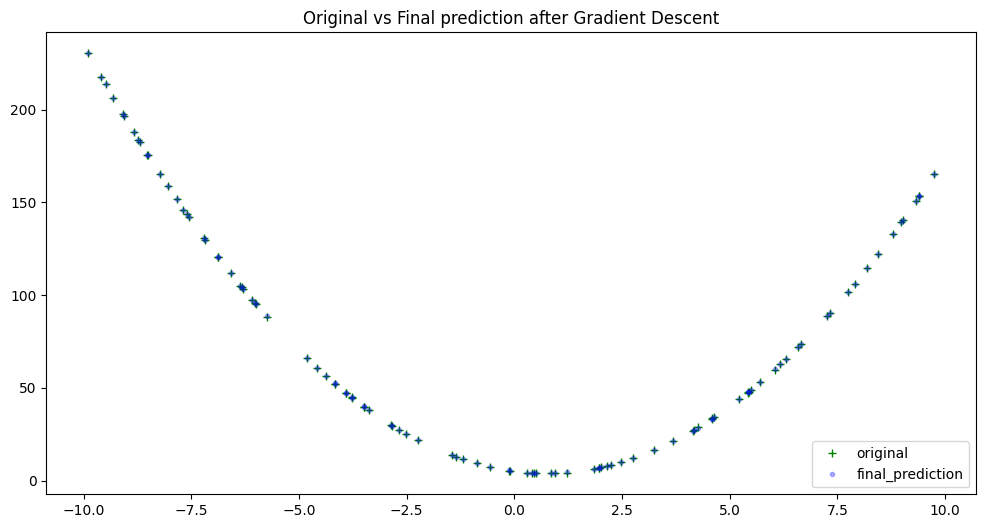

In [103]:
plt.figure(figsize=(12,6))
plt.plot(xs, ys, 'g+', label = 'original')
plt.plot(xs, GD[2], 'b.', label = 'final_prediction',alpha=0.3)
plt.title('Original vs Final prediction after Gradient Descent')
plt.legend(loc = "lower right")
plt.show()

This trained model is showing vast improvements after it’s full training cycle. We can examine further by inspecting its final predicted coefficients $a$, $b$ and $c$.

In [104]:
print(f"Final Coefficients predicted: {GD[1]}")
print(f"Original Coefficients: {coeffs}")

Final Coefficients predicted: (np.float64(1.999912999271791), np.float64(-3.001287470759473), np.float64(4.9987696108855175))
Original Coefficients: [2, -3, 5]


Not too far off! A big improvement over the initial random model. Looking at the plot of the loss reduction over training offers further insights.


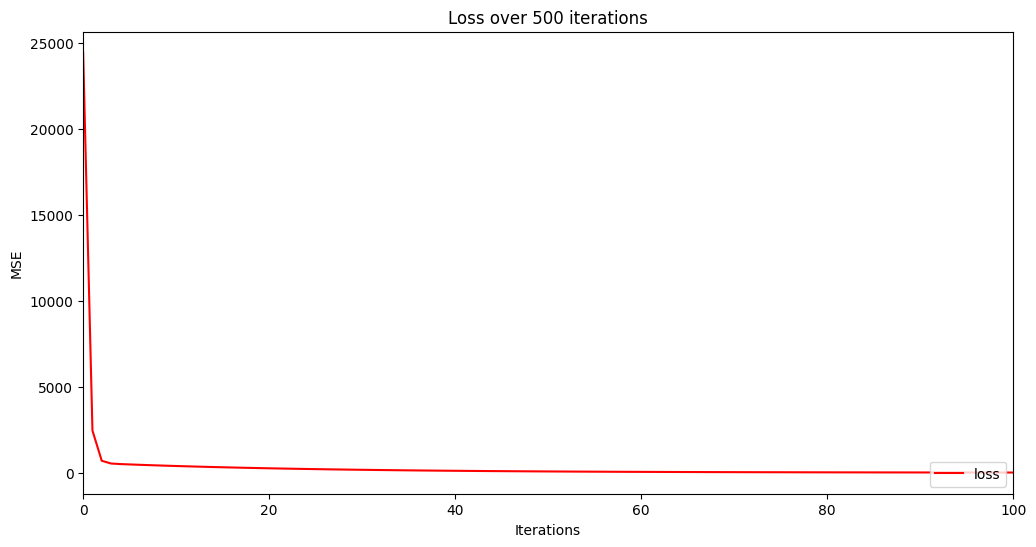

In [105]:
plt.figure(figsize=(12, 6))
plt.plot(GD[3], 'r-', label = 'loss')
# plt.xlim(0,50)
plt.title('Loss over 500 iterations')
plt.legend(loc="lower right")
plt.xlim((0,100))
plt.xlabel('Iterations')
plt.ylabel('MSE')
plt.show()

We observe that the model loss reached close to zero, to give us our more accurate coefficients. We can also see there was no major improvement in loss after about 100 epochs. An alternative strategy would be to add some kind of condition to the training step that stops training when a certain minimum loss threshold has been reached. This would prevent excessive training and potential over-fitting for the model.

### Going Further: Batch vs. Mini-Batch Gradient Descent

What we have implemented so far is called **Batch Gradient Descent**. This is because we calculate the gradient using the entire training dataset (our batch of 100 points) in every single step.

**Pros:**
It provides a stable and accurate estimate of the gradient, leading to smooth convergence.

**Cons:**
It is computationally very expensive. Imagine if our dataset had millions of points! Calculating the gradient over all of them for every single update would be incredibly slow.

---

A more popular and efficient alternative is **Mini-Batch Gradient Descent**.

In Mini-Batch GD, we shuffle the dataset and then divide it into small batches (e.g., 32 samples per batch). We then calculate the gradient and update the weights based on each mini-batch, one by one. One pass through all the mini-batches is called one **epoch**.

**Pros:**
- It's much faster than Batch GD.
- It introduces some noise into the gradient estimates, which can sometimes help the model escape from poor local minima.

**Cons:**
The convergence is not as smooth as with Batch GD; the loss can fluctuate.

Let's implement a simple Mini-Batch Gradient Descent to see the difference.


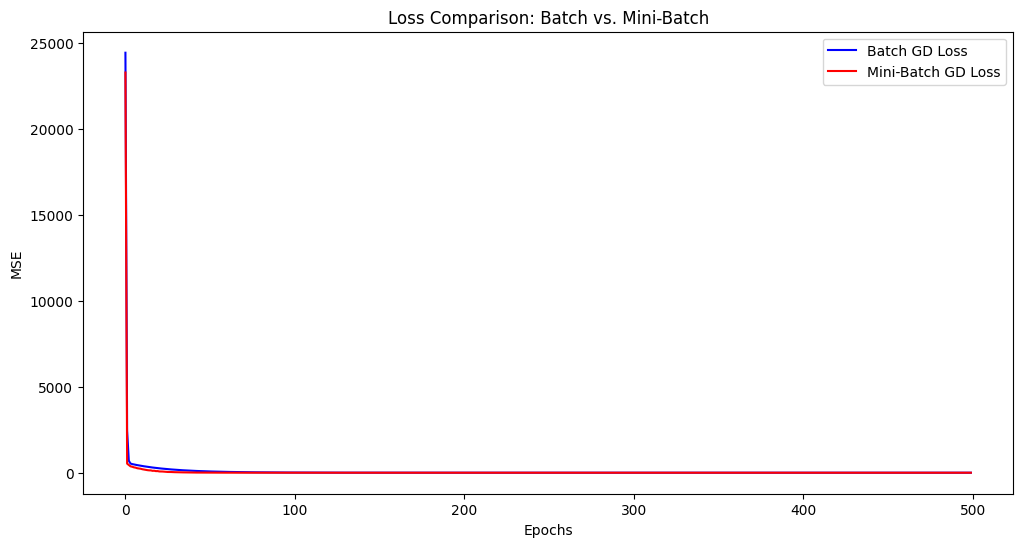

In [106]:
def mini_batch_gradient_descent(epochs, lr, batch_size):
    """
    Perform mini-batch gradient descent.

    Args:
        epochs: number of iterations to perform.
        lr: specified learning rate
        batch_size: number of samples per mini-batch

    Returns: Tuple containing (final loss, final coefficients, list of losses per batch)
    """
    losses = []
    # Start with our initial random coefficients
    coeffs_to_test = rand_coeffs

    # Convert data to numpy arrays for easier slicing
    X_data = np.array(hundred_xs)
    Y_data = np.array(ys)

    for i in range(epochs):
        # Shuffle data at the beginning of each epoch
        # This is crucial for mini-batch GD to work well!
        p = np.random.permutation(len(X_data))
        X_data, Y_data = X_data[p], Y_data[p]

        epoch_loss = []
        # Iterate over mini-batches
        for j in range(0, len(X_data), batch_size):
            # Get the current mini-batch
            X_batch = X_data[j:j+batch_size]
            Y_batch = Y_data[j:j+batch_size]

            # Calculate gradient and update on the mini-batch
            loss, new_coeffs, _ = calc_gradient_2nd_poly_for_GD(coeffs_to_test, X_batch, Y_batch, lr)
            coeffs_to_test = new_coeffs
            epoch_loss.append(loss)

        # Average loss for the epoch
        losses.append(np.mean(epoch_loss))

    # Return the final results after all epochs
    final_y_bar = eval_2nd_degree(coeffs_to_test, hundred_xs)
    final_loss = loss_mse(ys, final_y_bar)

    return final_loss, coeffs_to_test, losses

# Run Mini-Batch GD
# Note: We can often use fewer epochs and a slightly larger learning rate
MGD = mini_batch_gradient_descent(epochs=500, lr=0.0001, batch_size=16)

# Plotting the loss curves for comparison
plt.figure(figsize=(12, 6))
# We only plot the first 500 losses from Batch GD for a fair comparison
plt.plot(GD[3][:500], 'b-', label = 'Batch GD Loss')
plt.plot(MGD[2], 'r-', label = 'Mini-Batch GD Loss')
plt.title('Loss Comparison: Batch vs. Mini-Batch')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

In the comparison plot, you can see that the Mini-Batch GD loss curve (in red) is much noisier than the smooth Batch GD curve (in blue). This is expected because each update is based on only a small, random subset of the data. However, both methods converge to a very low loss, with Mini-Batch often getting there much faster in terms of wall-clock time on large datasets.

### Things to Try

1. **Change the polynomial:**
   Change the `coefficients` array and try a different polynomial instead of our $x^2$. For example, try to fit the model to a function like:
   $$
   y = 2x^2 - 3x + 5
   $$

2. **Experiment with the learning rate:**
   Increase or decrease the learning rate to see how many iterations it takes to converge. What happens if you use a huge learning rate (e.g., `lr = 0.1`)? Does it even converge?

3. **Higher-degree polynomials:**
   Take a degree 5 polynomial with 5 roots and try different initializations instead of random ones. Does it converge to different values for different initializations? Why does initialization not matter as much in our case of $x^2$? *(Hint: Think about the shape of the loss function.)*

4. **Finding maxima:**
   Can you modify the algorithm to find a **maxima** of a function instead of a minima? *(Hint: What happens if you move in the direction of the gradient instead of against it?)*

5. **Experiment with batch size:**
   Experiment with `batch_size` in the `mini_batch_gradient_descent` function. What happens if `batch_size = 1`? What happens if `batch_size = 100` (the full dataset size)?

6. **Research Gradient Descent with Momentum:**
   What is **Gradient Descent with Momentum**, and how might it help with convergence speed or stability, especially with noisy gradients from Mini-Batch GD?


## **Additional Critical Thinking Questions**

1. You are doing full batch gradient descent using the entire training set. Is it necessary to shuffle the training data? Explain your
answer.

2. You would like to train a dog/cat image classifier using mini-batch gradient
descent. You have already split your dataset into train, dev and test sets. The classes
are balanced. You realize that within the training set, the images are ordered in such a
way that all the dog images come first and all the cat images come after. A friend tells
you: ”you absolutely need to shuffle your training set before the training procedure.”
Is your friend right? Explain.

3. Our loss function for this quadratic regression problem is convex, meaning it has only one global minimum. Can you think of a scenario or a type of model where the loss function might have many local minima? How would that make training with gradient descent more challenging?

### **Answers to Critical Thinking Questions**

1. No, it is not necessary to shuffle the training data for Batch Gradient Descent. In each step, the gradient is calculated by summing the contributions from every single data point in the training set. Since addition is commutative, the order in which you sum up these contributions does not change the final gradient value. Therefore, shuffling the data will have no effect on the training trajectory.

2. Yes, your friend is absolutely right. In Mini-Batch Gradient Descent, the model updates its weights after seeing each small batch. If the data is ordered, the first several batches will consist only of dog images. The model will start to learn that everything is a dog and will adjust its weights heavily towards that prediction. Then, suddenly, it will start seeing batches of only cat images. It will have to drastically shift its weights to unlearn what it just learned and start classifying cats. This will cause the training process to be highly unstable and inefficient. By shuffling the data at the start of each epoch, every mini-batch will likely contain a random mix of dogs and cats, providing a much more stable and representative gradient for each update step.

3. Deep neural networks are a prime example of models with highly non-convex loss functions, which can have many local minima. A local minimum is a point that is lower than its immediate neighbors but is not the lowest possible point in the entire landscape. This makes training challenging because Gradient Descent is a "greedy" algorithm—it only looks for the downhill direction locally. It might descend into a local minimum and get "stuck" there, thinking it has found the best solution, even though a much better solution (the global minimum) exists elsewhere. Techniques like using a smaller learning rate, momentum, or using SGD (whose noise can help "bounce" out of shallow local minima) are used to mitigate this problem.

In [117]:
def eval_2nd_degree(coeffs, x):
    """
    Function to return the output of evaluating a second degree polynomial,
    given a specific x value.

    Args:
        coeffs: List containing the coefficients a, b, and c for the polynomial.
        x: The input x value to the polynomial.

    Returns:
        y: The corresponding output y value for the second degree polynomial.

    """

    a = coeffs[0] * (x * x)
    b = coeffs[1] * x
    c = coeffs[2]
    y = a + b + c
    return y

hundred_xs = np.random.uniform(-10, 10, 100)
coeffs = [2,-3,5]

xs = []
ys = []
for x in hundred_xs:
    y  = eval_2nd_degree(coeffs, x)
    xs.append(x)
    ys.append(y)

In [119]:
y_bar = eval_2nd_degree(rand_coeffs, hundred_xs)

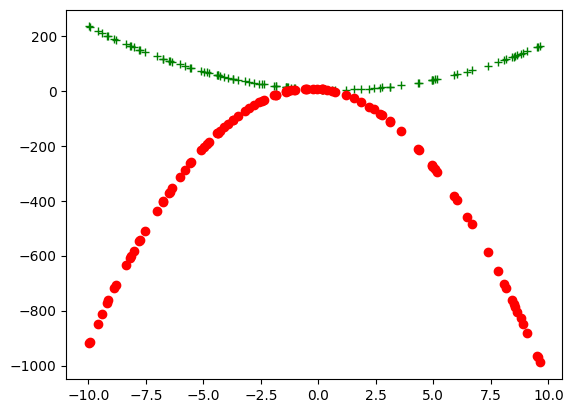

In [126]:
plt.plot(xs, ys, 'g+', label = 'original')
plt.plot(xs, y_bar,'ro')

In [120]:
def calc_gradient_2nd_poly(rand_coeffs, hundred_xs, ys):
    """
    calculates the gradient for a second degree polynomial.

    Args:
        coeffs: a,b and c, for a 2nd degree polynomial [ y = ax^2 + bx + c ]
        inputs_x: x input datapoints
        outputs_y: actual y output points

    Returns: Calculated gradients for the 2nd degree polynomial, as a tuple of its parts for a,b,c respectively.

    """

    a_s = []
    b_s = []
    c_s = []

    y_bars = eval_2nd_degree(rand_coeffs, hundred_xs)

    for x, y, y_bar in list(zip(hundred_xs, ys, y_bars)):    # take tuple of (x datapoint, actual y label, predicted y label)
        x_squared = x ** 2
        partial_a = x_squared * (y - y_bar)
        a_s.append(partial_a)
        partial_b = x * (y - y_bar)
        b_s.append(partial_b)
        partial_c = (y - y_bar)
        c_s.append(partial_c)

    num = [i for i in y_bars]
    n = len(num)

    gradient_a = (-2 / n) * sum(a_s)
    gradient_b = (-2 / n) * sum(b_s)
    gradient_c = (-2 / n) * sum(c_s)

    return (gradient_a, gradient_b, gradient_c)

In [121]:
def calc_gradient_2nd_poly_for_GD(coeffs, inputs_x, outputs_y, lr):
    """
    calculates the gradient for a second degree polynomial.

    Args:
        coeffs: a,b and c, for a 2nd degree polynomial [ y = ax^2 + bx + c ]
        inputs_x: x input datapoints
        outputs_y: actual y output points
        lr: learning rate

    Returns: Calculated gradients for the 2nd degree polynomial, as a tuple of its parts for a,b,c respectively.

    """
    a_s = []
    b_s = []
    c_s = []

    y_bars = eval_2nd_degree(coeffs, inputs_x)

    for x,y,y_bar in list(zip(inputs_x, outputs_y, y_bars)):    # take tuple of (x datapoint, actual y label, predicted y label)
        x_squared = x ** 2
        partial_a = x_squared * (y - y_bar)
        a_s.append(partial_a)
        partial_b = x * (y - y_bar)
        b_s.append(partial_b)
        partial_c = (y - y_bar)
        c_s.append(partial_c)

    num = [i for i in y_bars]
    n = len(num)

    gradient_a = (-2 / n) * sum(a_s)
    gradient_b = (-2 / n) * sum(b_s)
    gradient_c = (-2 / n) * sum(c_s)


    a_new = coeffs[0] - lr * gradient_a
    b_new = coeffs[1] - lr * gradient_b
    c_new = coeffs[2] - lr * gradient_c

    new_model_coeffs = (a_new, b_new, c_new)

    # update with these new coeffs:
    new_y_bar = eval_2nd_degree(new_model_coeffs, inputs_x)

    updated_model_loss = loss_mse(outputs_y, new_y_bar)
    return updated_model_loss, new_model_coeffs, new_y_bar

In [122]:
def gradient_descent(epochs, lr):
    """
    Perform gradient descent for a second degree polynomial.

    Args:
        epochs: number of iterations to perform of finding new coefficients and updatingt loss.
        lr: specified learning rate

    Returns: Tuple containing (updated_model_loss, new_model_coeffs, new_y_bar predictions, saved loss updates)

    """
    losses = []
    rand_coeffs_to_test = rand_coeffs
    for i in range(epochs):
        loss = calc_gradient_2nd_poly_for_GD(rand_coeffs_to_test, hundred_xs, ys, lr)
        rand_coeffs_to_test = loss[1]
        losses.append(loss[0])
    print(losses)
    return loss[0], loss[1], loss[2], losses  # (updated_model_loss, new_model_coeffs, new_y_bar, saved loss updates)

In [123]:
gd = gradient_descent(30000, 0.0003)

[np.float64(15028.351203319233), np.float64(1255.0624992959235), np.float64(546.3842124543544), np.float64(492.2566797035015), np.float64(471.6083781223689), np.float64(453.33070812228283), np.float64(435.83994421951866), np.float64(419.03093208670657), np.float64(402.87351395666786), np.float64(387.342249988394), np.float64(372.4128638879458), np.float64(358.06202909132367), np.float64(344.26732351364956), np.float64(331.00719407301733), np.float64(318.26092299064135), np.float64(306.0085954171476), np.float64(294.2310683145321), np.float64(282.90994054416694), np.float64(272.0275241140652), np.float64(261.56681654047503), np.float64(251.5114742806159), np.float64(241.84578719504495), np.float64(232.55465399974608), np.float64(223.6235586695921), np.float64(215.03854775630018), np.float64(206.78620858544502), np.float64(198.8536482984582), np.float64(191.2284737068675), np.float64(183.89877192729602), np.float64(176.85309176696458), np.float64(170.08042583060694), np.float64(163.57019

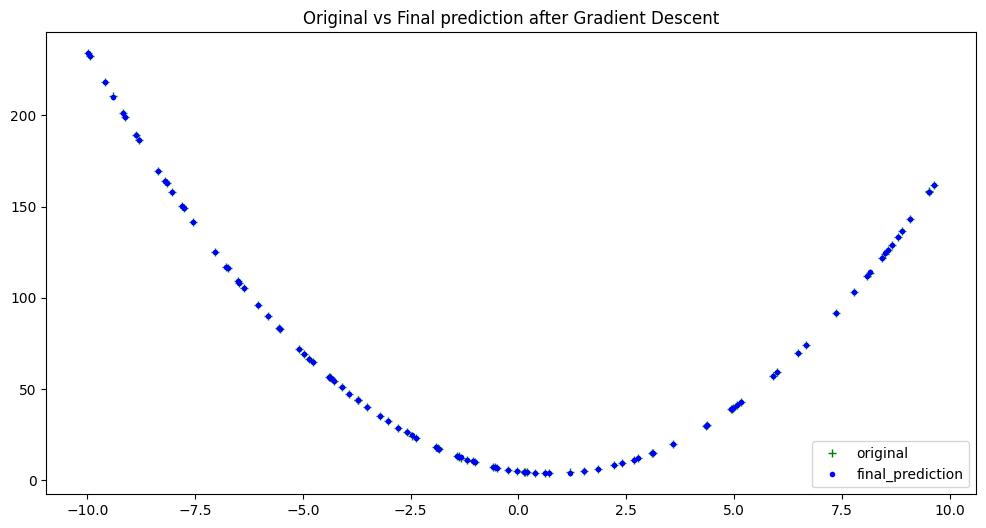

In [124]:
plt.figure(figsize=(12,6))
plt.plot(xs, ys, 'g+', label = 'original')
plt.plot(xs, gd[2], 'b.', label = 'final_prediction')
plt.title('Original vs Final prediction after Gradient Descent')
plt.legend(loc = "lower right")
plt.show()

In [133]:
Gd = gradient_descent(30000, 0.00001)

[np.float64(266732.52696087124), np.float64(245461.2900860437), np.float64(225889.91594671403), np.float64(207882.55765908022), np.float64(191314.22473713034), np.float64(176069.91548809526), np.float64(162043.81874376), np.float64(149138.57938655737), np.float64(137264.62257219417), np.float64(126339.53195799228), np.float64(116287.47762099998), np.float64(107038.68969484564), np.float64(98528.97407165458), np.float64(90699.26680733911), np.float64(83495.22413722693), np.float64(76866.84525617659), np.float64(70768.12524475921), np.float64(65156.73573234053), np.float64(59993.73108042876), np.float64(55243.278046801024), np.float64(50872.407053906565), np.float64(46850.78333501171), np.float64(43150.496369527384), np.float64(39745.86614591365), np.float64(36613.26490736107), np.float64(33730.953142920516), np.float64(31078.928685636576), np.float64(28638.78787021918), np.float64(26393.597786498318), np.float64(24327.778741926515), np.float64(22426.99611725854), np.float64(20678.060864

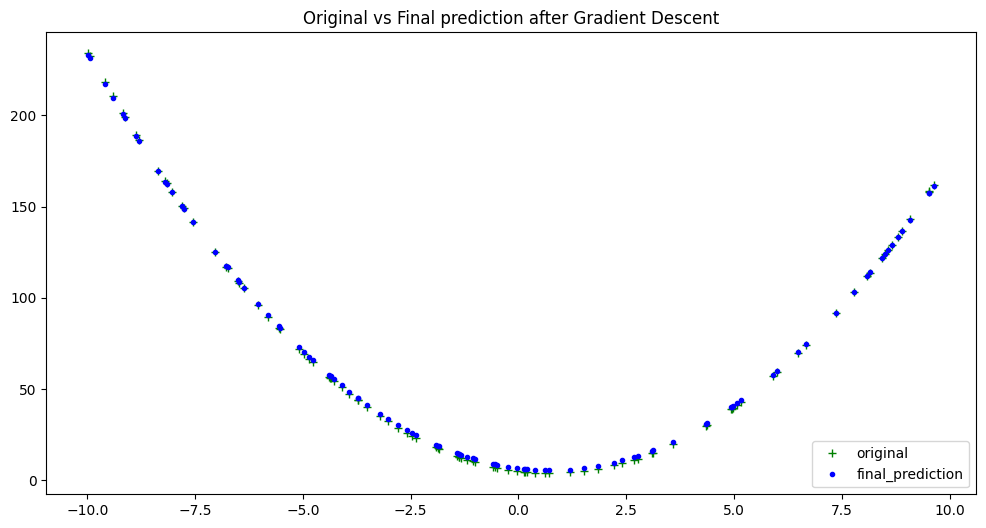

In [135]:
plt.figure(figsize=(12,6))
plt.plot(xs, ys, 'g+', label = 'original')
plt.plot(xs, Gd[2], 'b.', label = 'final_prediction')
plt.title('Original vs Final prediction after Gradient Descent')
plt.legend(loc = "lower right")
plt.show()

In [136]:
print(f"Final Coefficients predicted: {Gd[1]}")
print(f"Original Coefficients: {coeffs}")

Final Coefficients predicted: (np.float64(1.9737786874280623), np.float64(-2.9827758191583946), np.float64(6.629430091868797))
Original Coefficients: [2, -3, 5]
